# Otimização por Múltiplos Enxames Aplicada ao Escalonamento Dinâmico de Projetos de Software


### QP2. Como o desempenho do algoritmo proposto se compara ao de algoritmos da literatura quando aplicados ao DSPSP?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, friedmanchisquare

from dspsp_analysis import metrics_dataset

%matplotlib inline

data = metrics_dataset(filepath="../hypervolume/metrics-rq2-i01-all.csv")

In [43]:
def hv_mean(data, instance_id, algorithm_id, grouping="event"):
    df = data[(data.algorithm ==  algorithm_id) & (data.instance == instance_id)]
    df = df.groupby(["instance", "algorithm", grouping], as_index=False)["hypervolume"].mean()
    return df


def hv_measures(data, grouping="event", limit=None):
    instance_ids = list(data.instance.unique())
    algorithm_ids = list(data.algorithm.unique())
    measures = {}
    for inst in instance_ids:
        measures[inst] = {}
        for alg in algorithm_ids:
            measures[inst][alg] = hv_mean(data, inst, alg, grouping)[:limit]
    return measures


def plot_hv(data, inst, algorithms):
    plt.title("Instância {} \n{}".format(inst, " x ".join(algorithms)))
    plt.xlabel("Pontos de reescalonamento")
    plt.ylabel("Hipervolume")
    for alg in algorithms:
        plt.plot(data[inst][alg].hypervolume, "-o", markersize=3, lw=.5)
    plt.legend(algorithms, loc="lower right")
    plt.show()
    

def boxplot_hv(data, inst, algorithms):
    plt.title("Instância {} \n{}".format(inst, " x ".join(algorithms)))
    plt.ylabel("Hipervolume")
    plt.boxplot([data[inst][alg].hypervolume for alg in algorithms], labels=algorithms)
    plt.show()
    

def combined_plot_hv(data, inst, algorithms):
    plt.title("Instância {} \n{}".format(inst, " x ".join(algorithms)))

    plt.subplot(1, 2, 1)
    plt.xlabel("Pontos de reescalonamento")
    plt.ylabel("Hipervolume")
    for alg in algorithms:
        plt.plot(data[inst][alg].hypervolume, "-o", markersize=3, lw=.5)
    plt.legend(algorithms, loc="lower right")
    
    plt.subplot(1, 2, 2)
    plt.boxplot([data[inst][alg].hypervolume for alg in algorithms], labels=algorithms)


    plt.show()
    
    

In [44]:
hv_execution = hv_measures(data, grouping="execution", limit=5)
hv_event = hv_measures(data, limit=80)

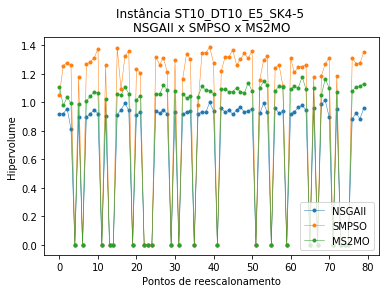

In [45]:
inst = "ST10_DT10_E5_SK4-5"
algorithms = ["NSGAII", "SMPSO", "MS2MO"]    
plot_hv(hv_event, inst, algorithms)

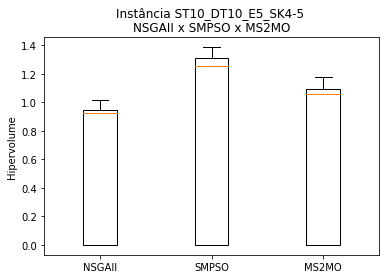

In [46]:
boxplot_hv(hv_event, inst, algorithms)

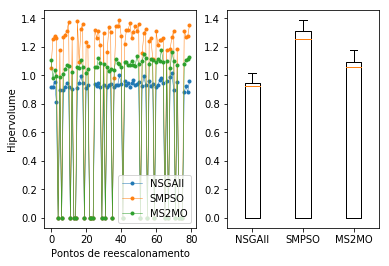

In [47]:
combined_plot_hv(hv_event, inst, algorithms)

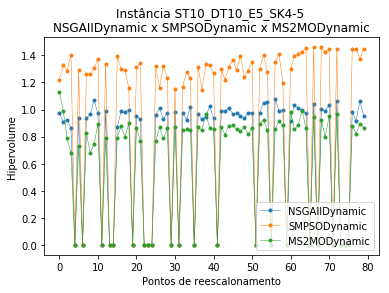

In [12]:
algorithms = ["NSGAIIDynamic", "SMPSODynamic", "MS2MODynamic"]    
plot_hv(hv_event, inst, algorithms)

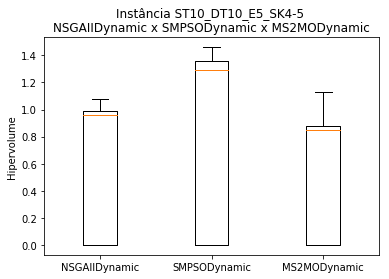

In [13]:
boxplot_hv(hv_event, inst, algorithms)